<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Findings</a></span></li></ul></li><li><span><a href="#BAV-Data-Pre-Processing" data-toc-modified-id="BAV-Data-Pre-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>BAV Data Pre-Processing</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Quick-look-at-the-data" data-toc-modified-id="Quick-look-at-the-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Quick look at the data</a></span></li><li><span><a href="#Encoding" data-toc-modified-id="Encoding-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Encoding</a></span></li><li><span><a href="#Isolating-the-Target-Variable" data-toc-modified-id="Isolating-the-Target-Variable-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Isolating the Target Variable</a></span></li><li><span><a href="#PCA-With-Scaling" data-toc-modified-id="PCA-With-Scaling-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>PCA With Scaling</a></span></li><li><span><a href="#PCA-Without-Scaling" data-toc-modified-id="PCA-Without-Scaling-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>PCA Without Scaling</a></span></li></ul></li><li><span><a href="#PCA-Correlation-with-Features" data-toc-modified-id="PCA-Correlation-with-Features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA Correlation with Features</a></span></li><li><span><a href="#Factor-Analysis" data-toc-modified-id="Factor-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Factor Analysis</a></span><ul class="toc-item"><li><span><a href="#Factoring-Down-to-8" data-toc-modified-id="Factoring-Down-to-8-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Factoring Down to 8</a></span></li><li><span><a href="#Inspecting-and-Naming-the-Factors" data-toc-modified-id="Inspecting-and-Naming-the-Factors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Inspecting and Naming the Factors</a></span></li></ul></li><li><span><a href="#Next-Steps" data-toc-modified-id="Next-Steps-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Next Steps</a></span><ul class="toc-item"><li><span><a href="#File-Save-Outs" data-toc-modified-id="File-Save-Outs-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>File Save Outs</a></span></li></ul></li></ul></div>

## Summary

The goal of this notebook is to attempt to reduce the dimensionality of the BAV data and address any data scaling issues.

Tecniques explored included PCA with 2 components and PCA at a 90% explained variance threshold (determined by SKLearn) on both scaled and unscaled data.

### Findings

- Overall, the PCA worked to explain more variance in the dataset without scaling than with. However, while the reduction from 55 features to 15 was significant, the loss in interpretability was drastic. The results of modeling data in this form would be difficult to explain and impossible to interpret.   


- Because of the loss of interpretablilty, Factor Analysis was conducted. the results were 8 distinct factors/clusters that explain about 70% of the variance in the features. While there's a bit more thinking to do on the names of these factors, this is promising and will be brought forward into the modeling phase.   


- In addition to the Factor Analysis, I'm specifically interested to explore the effects of: High Correlation Filtering, Low Variance Filtering, and Random Forrests for Column Selection as outlined in this article:   
https://thenewstack.io/3-new-techniques-for-data-dimensionality-reduction-in-machine-learning/

## BAV Data Pre-Processing

### Imports

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os
import numpy as np
import time

from pandas_datareader import data as pdr
from scipy.stats import norm
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

### Quick look at the data

In [2]:
# Load the Joined BAV data from EDA stage
BAV_df = pd.read_csv('../data/BAV_join.csv', header=0, index_col=0)
BAV_df.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,Year
Acura,9.632626,0.588681,2.131318,0.536944,3.303892,1.774005,1.254666,8.081687,12.271390,8.301122,...,15.710160,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579,2018
Alfa Romeo,5.360558,0.771191,1.648400,0.351125,2.040411,0.716439,1.271231,11.130420,17.817520,13.124450,...,17.267210,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341,2018
Aston Martin,6.165359,0.777430,1.568270,0.347223,2.272228,0.788971,1.219220,11.082860,18.486561,13.061050,...,16.646311,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667,2018
Audi,8.403893,0.773740,1.970076,0.536370,3.247704,1.741970,1.524328,9.503444,16.048050,11.872650,...,18.800541,8.386318,15.85582,12.400040,6.730000,10.951970,21.809719,11.357830,8.388798,2018
Bentley,6.453038,0.790917,1.605834,0.500165,2.720615,1.360756,1.270082,11.227820,19.309050,14.956740,...,19.569870,11.032830,12.52582,12.685470,11.473560,9.141562,34.941780,9.720911,10.133530,2018


In [3]:
BAV_df.describe()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,Year
count,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,...,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000
mean,12.209701,0.588415,2.544035,0.477370,2.414359,1.303382,1.505913,9.397467,11.285562,9.608629,...,7.968883,10.177757,12.280784,15.192883,5.445757,10.849244,8.087944,10.250318,6.298799,2018.500000
std,8.713072,0.121253,0.537333,0.212133,1.138746,1.146969,0.487146,2.483562,2.635689,2.600862,...,4.555316,4.021893,4.398676,5.227095,2.280908,2.704662,4.441919,3.231548,2.558453,0.500041
min,0.000000,0.311086,0.844490,0.040534,0.361947,0.063010,0.323127,1.993662,3.848764,2.237904,...,0.957738,2.520318,1.168887,2.830153,0.000000,0.743542,0.777813,1.619330,0.000000,2018.000000
25%,5.847472,0.504416,2.194867,0.336441,1.405593,0.481978,1.182708,7.553335,9.481501,7.762816,...,5.082789,7.423602,9.070712,11.420812,4.006169,9.046549,5.456322,8.055205,4.471148,2018.000000
50%,9.905344,0.571779,2.465221,0.420696,2.403746,0.934364,1.435254,8.978947,10.893910,9.208430,...,6.409295,9.271638,11.455115,14.337950,4.950425,10.536130,6.766305,9.639658,5.844792,2018.500000
75%,16.737939,0.651827,2.809550,0.566624,3.309856,1.711841,1.739238,10.843252,12.596953,11.000907,...,9.035676,11.916027,14.547902,18.198491,6.349181,12.262418,9.034813,11.721245,7.648178,2019.000000
max,50.524490,1.298806,5.316035,1.729260,5.400015,9.338032,6.904500,27.744989,29.265770,28.022829,...,32.493820,44.155819,33.851509,38.595451,30.147461,24.366600,39.617592,31.832420,20.036560,2019.000000


In [4]:
BAV_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6058 entries, Acura to Thomson Reuters
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Recommend_to_a_friend_pct    6058 non-null   float64
 1   Energized_Differentiation_C  6058 non-null   float64
 2   Relevance_C                  6058 non-null   float64
 3   Esteem_C                     6058 non-null   float64
 4   Knowledge_C                  6058 non-null   float64
 5   Brand_Stature_C              6058 non-null   float64
 6   Brand_Strength_C             6058 non-null   float64
 7   Different_pct                6058 non-null   float64
 8   Distinctive_pct              6058 non-null   float64
 9   Unique_pct                   6058 non-null   float64
 10  Dynamic_pct                  6058 non-null   float64
 11  Innovative_pct               6058 non-null   float64
 12  Leader_pct                   6058 non-null   float64
 13  Reliable

### Encoding

First clean-up is the 'year' column. While it's a number, the scale is drastically different.

In [5]:
# Change 'year' to 'yr_2019' encoded with a 1 if true or 0 if 2018.
BAV_df['yr_2019'] = BAV_df['Year'].apply(lambda x: 0 if x==2018 else 1)

In [6]:
print(BAV_df['yr_2019'].sample(10))

Apple            1
Alpo Snaps       1
Genentech        0
Lotrimin         0
Planters         0
Vespa            0
Club Monaco      0
MiraLAX          0
ALDI             0
Louis Vuitton    0
Name: yr_2019, dtype: int64


In [7]:
BAV_df['yr_2019'].value_counts()

0    3029
1    3029
Name: yr_2019, dtype: int64

An even and equall number of 0s and 1s. As expected.  
Now drop the relic 'Year' column.

In [8]:
BAV_df = BAV_df.drop(['Year'], axis=1)
BAV_df.head(3)

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,yr_2019
Acura,9.632626,0.588681,2.131318,0.536944,3.303892,1.774005,1.254666,8.081687,12.271390,8.301122,...,15.710160,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579,0
Alfa Romeo,5.360558,0.771191,1.648400,0.351125,2.040411,0.716439,1.271231,11.130420,17.817520,13.124450,...,17.267210,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341,0
Aston Martin,6.165359,0.777430,1.568270,0.347223,2.272228,0.788971,1.219220,11.082860,18.486561,13.061050,...,16.646311,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667,0


### Isolating the Target Variable

In [9]:
X = BAV_df.drop(['Recommend_to_a_friend_pct'], axis=1)
y = BAV_df['Recommend_to_a_friend_pct']

### PCA With Scaling

Before modeling, exploring ways to reduce the dimensionality of the dataset to simplify and speed up the process.   
Starting with a Principal Component Analysis.

In [38]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# Start with scaling to 2 components
pca = PCA(n_components=2)
pc_train = pca.fit_transform(X_train)
principalComponents = pca.transform(X_test)
principal_BAV = pd.DataFrame(data = principalComponents, columns = ['pc 1', 'pc 2'])

In [41]:
y_test = pd.DataFrame(y_test)
principal_BAV.index = y_test.index

In [42]:
BAV_pca2_df = pd.concat([principal_BAV, y_test], axis=1)

In [43]:
BAV_pca2_df.sample(10)

,pc 1,pc 2,Recommend_to_a_friend_pct
Urban Outfitters,-2.566193,2.218761,11.119970
Big Brothers Big Sisters,4.277704,-1.901640,12.701690
Allianz,-2.982198,-1.426987,3.377270
VISA,7.406398,-2.024941,29.682289
Australia,0.436417,2.932212,11.836110
Lexus,1.143027,4.973958,9.613838
Star Alliance,-4.001312,-0.210430,4.549416
Resolve (cleaning products),0.469796,-4.731405,20.721109
Vera Wang,-0.556680,6.352626,11.186080
Shark Tank,1.061629,6.504978,18.067471


In [44]:
# Ensuring we still have the same number of columns as before (30% of 6058 = 1818)
BAV_pca2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1818 entries, Stephen Curry to LenovoEMC
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pc 1                       1818 non-null   float64
 1   pc 2                       1818 non-null   float64
 2   Recommend_to_a_friend_pct  1818 non-null   float64
dtypes: float64(3)
memory usage: 56.8+ KB


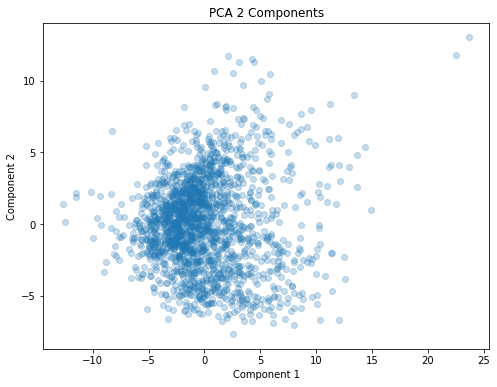

In [45]:
figure(figsize=(8, 6))
plt.scatter(BAV_pca2_df['pc 1'], BAV_pca2_df['pc 2'], alpha=.25)
plt.title('PCA 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [46]:
pca.explained_variance_ratio_

array([0.24882496, 0.18087231])

In [47]:
print('Makes more sense why the 2 component PCA is largely a blob. The explained variance is only {}. Will have to try with a larger number of components'.format(pca.explained_variance_ratio_.sum()))

Makes more sense why the 2 component PCA is largely a blob. The explained variance is only 0.4296972726412425. Will have to try with a larger number of components


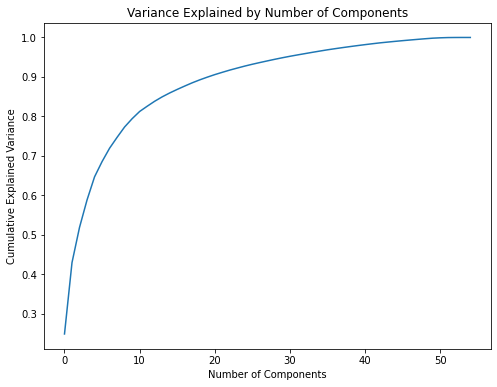

In [50]:
# Have SKLearn select the number of components to explain 90% of the variance
# Start by visualizing
pca = PCA()
pca_train = pca.fit(X_train)
pca_test = pca.transform(X_test)
figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Variance Explained by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');
plt.show()

Looks like 20 components will explain about 90% of the variance.  
Let's find out exactly how many.

In [51]:
pca = PCA(n_components = 0.9)
pca_train = pca.fit(X_train)
pca_test = pca.transform(X_test)
pca.n_components_

21

In [55]:
# Reassemble X and y with 21 components
X = pd.DataFrame(data = pca.transform(X))
y = pd.DataFrame(y)
X.index = y.index
BAV_pca21_df = pd.concat([X, y], axis=1)

In [56]:
BAV_pca21_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6058 entries, Acura to Thomson Reuters
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   0                          6058 non-null   float64
 1   1                          6058 non-null   float64
 2   2                          6058 non-null   float64
 3   3                          6058 non-null   float64
 4   4                          6058 non-null   float64
 5   5                          6058 non-null   float64
 6   6                          6058 non-null   float64
 7   7                          6058 non-null   float64
 8   8                          6058 non-null   float64
 9   9                          6058 non-null   float64
 10  10                         6058 non-null   float64
 11  11                         6058 non-null   float64
 12  12                         6058 non-null   float64
 13  13                         6058 non-nu

In [57]:
BAV_pca21_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Recommend_to_a_friend_pct
creditcards.com,54.201818,18.595035,-3.465828,-5.560883,-6.764918,12.916266,0.529816,-11.911032,-0.370112,8.808196,...,2.929560,0.451455,-11.223419,4.344647,0.944479,1.575373,16.556048,4.466770,-2.584621,4.356225
Microsoft,86.423980,28.148858,15.464335,-3.319038,-1.237943,9.067289,-5.141479,-7.040141,0.377537,5.190057,...,1.084604,-3.265521,-15.528401,6.908675,-5.080359,-3.974249,20.000488,10.678474,-2.976477,29.577900
Abercrombie & Fitch,47.378462,32.138821,-8.437074,16.392839,-7.147483,9.494191,-7.283328,-12.444844,1.770378,12.490536,...,2.748454,-3.595576,-16.020290,1.585366,-2.655007,-3.738686,9.344716,2.990813,-5.081314,12.608980
Oxygen,48.615702,21.706598,-12.953217,-0.605762,0.150157,13.392239,-1.582160,-7.318009,-1.077903,5.686585,...,1.637493,-0.441307,-10.437296,4.539946,-0.132517,-2.041688,13.498317,3.884442,-4.913475,10.691210
Syfy (channel),56.834455,35.451705,-18.274692,-2.379688,12.116770,4.420609,2.950589,-0.848894,4.262325,3.373961,...,3.719323,-2.144639,-11.110487,7.358783,2.163008,-5.953401,14.994496,4.319138,0.814595,18.561899
American Family Insurance,50.838108,9.052317,-5.793284,-2.938716,-5.041904,16.150299,0.073044,-9.809376,3.240742,5.154227,...,2.311789,-2.493729,-9.344021,4.837737,1.053003,0.057245,13.955986,4.751938,-3.740074,5.974168
North Korea,20.720372,26.838847,1.753086,2.651363,7.880505,25.228177,8.426180,-0.739220,9.377598,27.203349,...,-1.539967,-10.584552,-5.698278,0.895576,-3.381984,-3.885915,7.363183,6.414220,-3.881655,4.281029
Novo Nordisk,52.917828,19.588237,-1.070467,-2.515967,-6.712127,11.373453,3.229004,-9.493812,2.237752,3.849440,...,-0.695245,-0.495758,-14.464201,2.503905,1.523689,-6.262144,15.379867,7.219052,-5.881075,0.000000
Kevlar,63.631078,22.204747,3.704600,4.531118,-2.348803,1.607228,11.796414,-10.742910,2.369041,2.629915,...,2.384137,-5.769376,-10.043453,6.913466,-5.081561,-1.306955,16.570514,8.276834,-3.737904,8.233458
Credit Suisse,41.933677,20.800010,-0.284204,2.300587,-5.407292,13.682033,0.291834,-8.070035,4.133566,4.135282,...,-2.867302,-1.485224,-10.858450,4.442240,0.808574,-0.364700,10.950325,4.350026,-4.225334,3.482583


### PCA Without Scaling

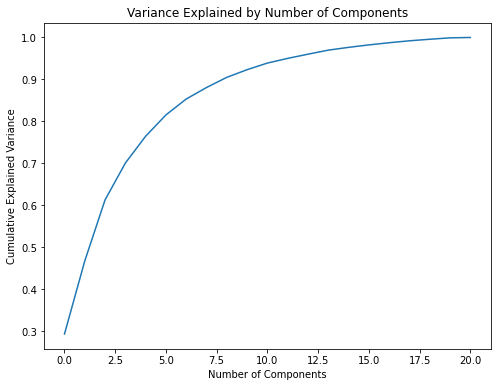

In [61]:
# Have SKLearn select the number of components to explain 90% of the variance
# Start by visualizing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

pca_ns = PCA()
pca_train_ns = pca_ns.fit(X_train)
pca_test_ns = pca_ns.transform(X_test)
figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_ns.explained_variance_ratio_))
plt.title('Variance Explained by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');
plt.show()

Without scaling seems to eplain more variance by using less components.  
Let's compute the 90% threshold.

In [62]:
pca_ns = PCA(n_components = 0.9)
pca_train_ns = pca_ns.fit(X_train)
pca_test_ns = pca_ns.transform(X_test)
pca_ns.n_components_

9

In [63]:
# Reassemble DataFrame with 9 components
X = pd.DataFrame(data = pca_ns.transform(X))
y = pd.DataFrame(y)
X.index = y.index
BAV_pca9_df = pd.concat([X, y], axis=1)
BAV_pca9_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6058 entries, Acura to Thomson Reuters
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   0                          6058 non-null   float64
 1   1                          6058 non-null   float64
 2   2                          6058 non-null   float64
 3   3                          6058 non-null   float64
 4   4                          6058 non-null   float64
 5   5                          6058 non-null   float64
 6   6                          6058 non-null   float64
 7   7                          6058 non-null   float64
 8   8                          6058 non-null   float64
 9   Recommend_to_a_friend_pct  6058 non-null   float64
dtypes: float64(10)
memory usage: 649.6+ KB


In [64]:
BAV_pca9_df.sample(10)

,0,1,2,3,4,5,6,7,8,Recommend_to_a_friend_pct
Crystal Light,11.809182,-2.288150,-11.320860,4.839018,4.859450,2.872210,-1.472457,-1.458693,1.817653,19.736490
Jameson,-9.337473,-1.214445,-3.112411,3.625538,-11.033857,3.423720,0.671664,-2.379148,0.170156,11.010470
San Pellegrino,-6.517941,-5.808237,-0.886018,9.359412,0.872207,2.438402,0.452546,-3.861869,-0.019518,10.535250
Diesel (clothing),-15.933761,4.859958,-0.955148,7.801997,1.896333,-6.477051,-7.531801,4.370113,1.964740,6.328249
Judaism (religion),-13.862287,-18.695312,-5.181016,-6.886769,-9.202006,3.202245,10.702605,-1.867274,5.604087,0.000000
Nexxus,-7.088632,-7.298443,5.207173,6.645959,-0.039224,-1.448235,-1.808570,-3.380233,-2.871175,11.552280
Bridgestone,9.567115,-3.212865,12.748732,-3.701748,-10.062765,-1.887234,-7.320252,5.596333,-3.205523,18.744120
Pretzel Crisps,3.243312,-3.427697,-14.610117,4.613724,5.751008,3.790245,-2.356573,-2.989599,3.819639,13.555260
Banquet,16.848642,-11.518122,-10.020155,3.480844,-3.136841,-5.792499,2.041160,2.177752,2.290946,20.199869
Google,21.912797,33.474766,22.225956,-23.162003,4.846439,-2.908103,-1.347840,-5.960109,3.144561,47.268650


In [88]:
pca_ns.explained_variance_ratio_

array([0.29320901, 0.17417682, 0.14549534, 0.08774448, 0.06404461,
       0.05069881, 0.03797297, 0.02736717, 0.02422544])

The last 2 components aren't contributing very much.   
By dropping these, I can reduce to 7 components and still explain ~85% of the variance.

In [90]:
# Reducing to top 7 components
BAV_pca7_df = BAV_pca9_df.drop([7, 8], axis=1)
BAV_pca7_df.head()

,0,1,2,3,4,5,6,Recommend_to_a_friend_pct
Acura,-7.298675,3.722081,11.963241,6.518733,-3.427643,-2.175331,-3.959775,9.632626
Alfa Romeo,-22.050010,10.519381,14.381528,17.092795,-4.823393,6.934031,1.998752,5.360558
Aston Martin,-23.543067,9.806117,18.850971,21.719192,-7.964676,8.684333,2.255473,6.165359
Audi,-11.660744,12.818343,16.787929,11.675189,-4.620105,3.118687,-2.348438,8.403893
Bentley,-18.040956,14.545491,23.808210,25.837986,-10.017668,10.051529,7.553006,6.453038


## PCA Correlation with Features

Exploring how the 9 factors correlate with the raw data.

In [74]:
BAV_sorted.shape

(6058, 56)

In [82]:
BAV_pca9_df.head()

,0,1,2,3,4,5,6,7,8,Recommend_to_a_friend_pct
Acura,-7.298675,3.722081,11.963241,6.518733,-3.427643,-2.175331,-3.959775,-4.601171,-2.861801,9.632626
Alfa Romeo,-22.050010,10.519381,14.381528,17.092795,-4.823393,6.934031,1.998752,-1.682581,0.158633,5.360558
Aston Martin,-23.543067,9.806117,18.850971,21.719192,-7.964676,8.684333,2.255473,-5.366963,1.200633,6.165359
Audi,-11.660744,12.818343,16.787929,11.675189,-4.620105,3.118687,-2.348438,-2.336923,-1.495566,8.403893
Bentley,-18.040956,14.545491,23.808210,25.837986,-10.017668,10.051529,7.553006,-3.278463,2.037785,6.453038


In [84]:
corr.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,yr_2019
Recommend_to_a_friend_pct,1.000000,0.008697,0.705136,0.731980,0.784826,0.837132,0.468687,-0.190551,0.231135,-0.005409,...,-0.095982,0.476258,-0.006632,0.655977,-0.424043,0.233213,-0.207208,0.086747,0.590696,0.002059
Brand_Stature_C,0.837132,0.068586,0.732516,0.924120,0.835888,1.000000,0.539835,-0.262297,0.303936,-0.027976,...,-0.090162,0.578413,-0.114242,0.787801,-0.290116,0.319498,-0.085343,0.272039,0.620215,0.005231
Knowledge_C,0.784826,-0.100398,0.463248,0.624527,1.000000,0.835888,0.247564,-0.328763,0.205899,-0.127591,...,-0.133447,0.499393,-0.108631,0.526506,-0.255425,0.097643,-0.155394,0.059752,0.367826,0.002378
Esteem_C,0.731980,0.161094,0.775910,1.000000,0.624527,0.924120,0.621172,-0.220640,0.336636,0.024080,...,-0.045960,0.532846,-0.123471,0.868972,-0.304548,0.426163,-0.002491,0.386878,0.712833,0.012606
Best_Brand_pct,0.720247,0.327332,0.704192,0.834099,0.573790,0.809641,0.687569,-0.017561,0.474264,0.251695,...,0.009086,0.480457,0.053038,0.691746,-0.221683,0.369296,0.036102,0.362679,0.791054,0.021496


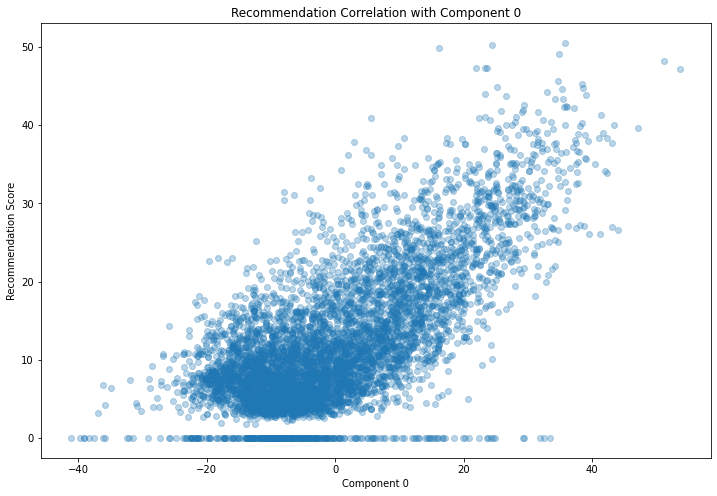

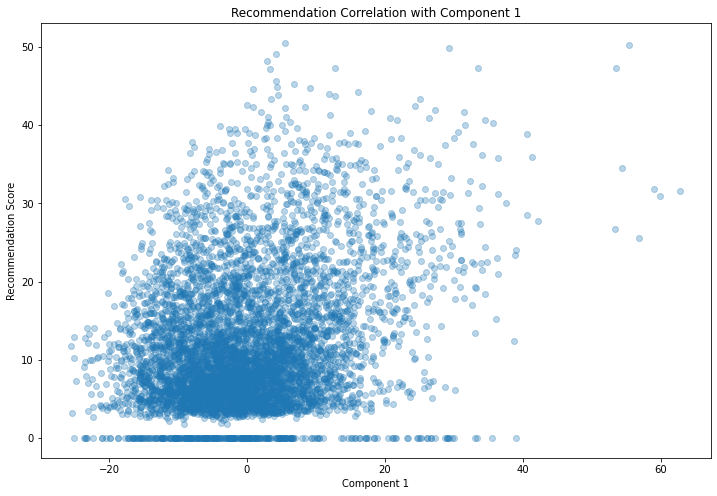

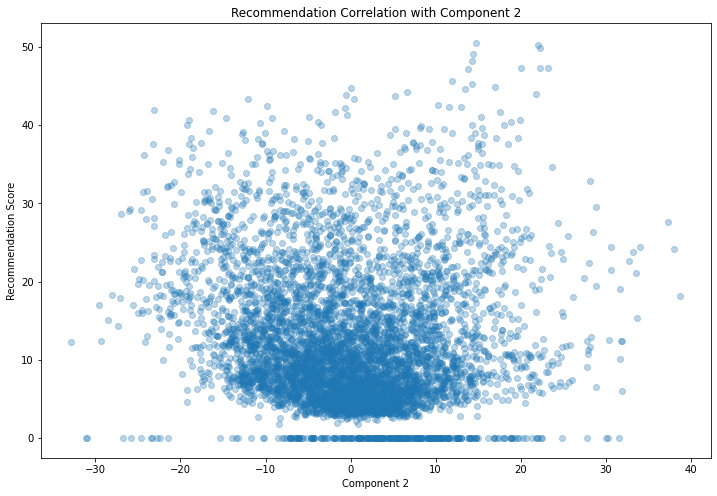

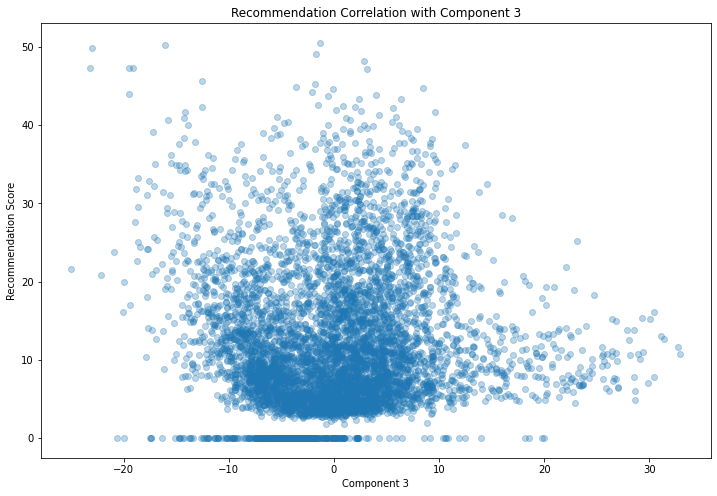

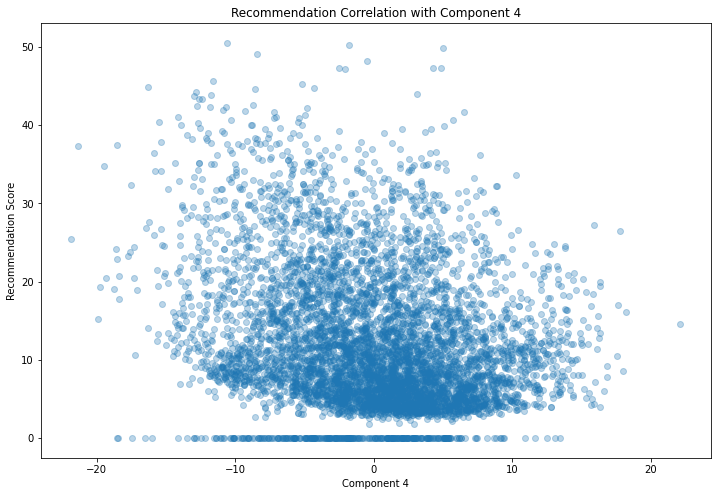

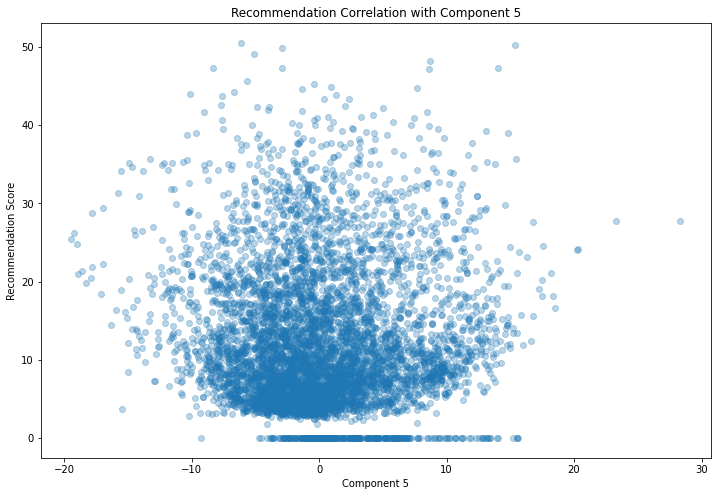

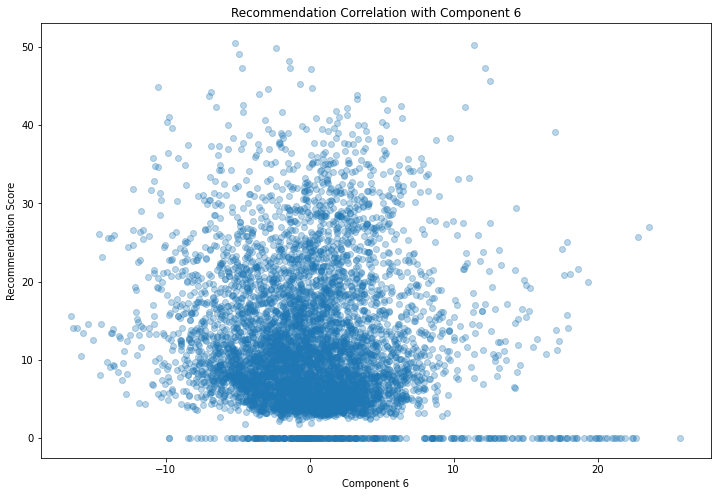

In [97]:
#Visualize each component
for i in range(7):
    plt.figure(figsize=(12, 8))
    plt.scatter(BAV_pca7_df[i], BAV_pca7_df['Recommend_to_a_friend_pct'], alpha=.3)
    plt.title('Recommendation Correlation with Component {}'.format(i))
    plt.xlabel('Component {}'.format(i))
    plt.ylabel('Recommendation Score')
    plt.show()

## Factor Analysis

The loss of interpretablilty in the PCA is disapointing. It doesn't seem like a viable option for dimensionality reduction on the BAV data—at least for explanatory puposes. Before moving into the modeling phase, there is one other technique that may prove valuable to explore in understanding and communicating the workings of the model—Factor Analyisis.   
https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [124]:
# Determining the factorability of the dataset
# Bartlett's Test want a p-value less than .05
BAV_feats = BAV_df.drop(['Recommend_to_a_friend_pct'], axis=1)
chi_square, p_val = calculate_bartlett_sphericity(BAV_feats)
chi_square, p_val

(566685.1813049208, 0.0)

Statistically significant.

In [125]:
# KMO test. Want a value above .6 for factorability
kmo_all, kmo_model = calculate_kmo(BAV_feats)
kmo_model

0.8372072572863931

Great shape for factor analysis.

In [126]:
# Check Eigen Values
fa = FactorAnalyzer(rotation=None)
fa.fit(BAV_feats)

ev, v = fa.get_eigenvalues()
ev

array([1.38066115e+01, 9.92025188e+00, 4.87087987e+00, 3.86464615e+00,
       3.18420891e+00, 2.14374687e+00, 1.85444745e+00, 1.48108949e+00,
       1.42987367e+00, 1.16074250e+00, 9.99327283e-01, 7.35130519e-01,
       6.99874861e-01, 6.14676600e-01, 5.28354029e-01, 4.87438945e-01,
       4.76735642e-01, 4.57506078e-01, 4.11164904e-01, 3.64856260e-01,
       3.56100428e-01, 3.19138582e-01, 3.11238891e-01, 2.75275633e-01,
       2.70601174e-01, 2.50108617e-01, 2.38186219e-01, 2.33778882e-01,
       2.23788400e-01, 2.10112626e-01, 2.04342730e-01, 1.89921809e-01,
       1.82496884e-01, 1.78120143e-01, 1.74988606e-01, 1.71485750e-01,
       1.56303808e-01, 1.51584988e-01, 1.42115507e-01, 1.37242072e-01,
       1.31253676e-01, 1.26464142e-01, 1.19525182e-01, 1.05042373e-01,
       1.03685491e-01, 9.72755677e-02, 9.11870209e-02, 8.83255976e-02,
       8.56285647e-02, 7.95874063e-02, 5.29025467e-02, 3.45053785e-02,
       1.22318492e-02, 3.89009749e-03, 2.72844723e-13])

In [127]:
ev_df = pd.DataFrame(data={'Eigen Value': ev})
ev_df

,Eigen Value
0,1.380661e+01
1,9.920252e+00
2,4.870880e+00
3,3.864646e+00
4,3.184209e+00
5,2.143747e+00
6,1.854447e+00
7,1.481089e+00
8,1.429874e+00
9,1.160742e+00


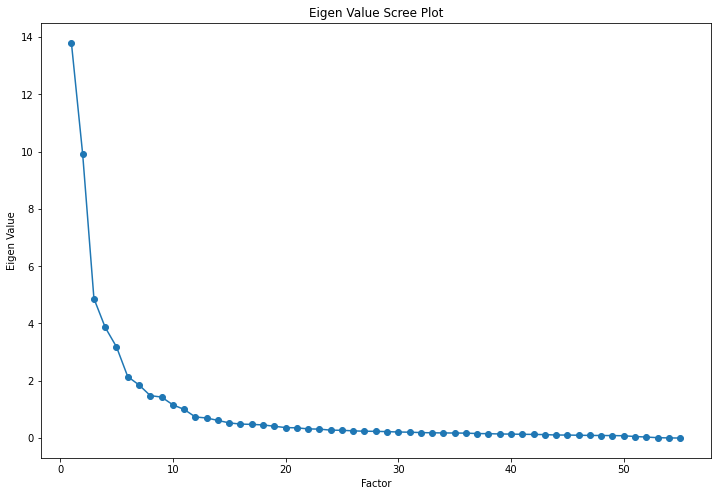

In [129]:
# Plot Eigen Values
plt.figure(figsize=(12, 8))
plt.scatter(range(1, 56), ev)
plt.plot(range(1, 56), ev)
plt.title('Eigen Value Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigen Value')
plt.show()

10 values greater than 1. Let's start with 10 values.

In [130]:
# Run Factor Analysis on 10 Factors
fa = FactorAnalyzer(rotation='varimax', n_factors=10)
fa.fit(BAV_feats)

FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

In [134]:
# Make DataFrame from fa.loadings_
factor_cols = ['Factor 0', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7', 'Factor 8', 'Factor 9']
loadings = pd.DataFrame(data=fa.loadings_, columns=factor_cols, index=BAV_feats.columns)
loadings

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
Energized_Differentiation_C,0.074562,0.600220,0.243183,0.692065,0.155306,-0.025440,0.244121,0.044045,-0.084774,0.052332
Relevance_C,0.760829,0.142821,-0.088437,0.103703,0.035553,0.209298,-0.024422,-0.128228,0.201915,0.056563
Esteem_C,0.927414,0.273816,-0.013838,-0.106636,-0.058504,0.113987,0.066824,-0.077101,-0.063524,0.002940
Knowledge_C,0.738543,-0.048422,-0.176310,-0.219086,0.342987,-0.201219,-0.081596,0.112440,-0.015863,-0.045015
Brand_Stature_C,0.937076,0.148811,-0.094489,-0.146700,0.142171,-0.014642,-0.001360,0.042286,-0.011051,-0.022053
Brand_Strength_C,0.555652,0.504153,0.082124,0.501556,0.140367,0.111369,0.147598,-0.030524,0.075061,0.075145
Different_pct,-0.228157,0.263068,0.092875,0.738858,0.106545,0.103367,0.013187,0.078557,0.156148,0.048234
Distinctive_pct,0.374095,0.204360,0.396917,0.509247,0.174363,-0.053991,0.131192,0.116224,-0.282178,0.008049
Unique_pct,0.018069,0.319925,0.254301,0.742992,0.217109,0.063353,0.080572,0.020935,-0.053940,0.050566
Dynamic_pct,0.026011,0.500432,0.150929,0.214405,0.195747,-0.104462,0.614953,0.171503,-0.182238,0.044702


In [136]:
# Get variance for each factor
variance_cols = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
variance = pd.DataFrame(data=fa.get_factor_variance(), columns=loadings.columns, index=variance_cols)
variance

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
SS Loadings,10.920187,6.507013,4.602272,3.766639,3.572142,3.256050,2.629058,2.512881,1.940950,1.423444
Proportion Variance,0.198549,0.118309,0.083678,0.068484,0.064948,0.059201,0.047801,0.045689,0.035290,0.025881
Cumulative Variance,0.198549,0.316858,0.400536,0.469020,0.533968,0.593169,0.640970,0.686659,0.721949,0.747830


Factors 8 and 9 aren't adding much clarity.   
Will try dropping to 8 factors and attempting to spot any clusters or groupings.

### Factoring Down to 8

In [137]:
# Run Factor Analysis on 8 Factors
fa = FactorAnalyzer(rotation='varimax', n_factors=8)
fa.fit(BAV_feats)

FactorAnalyzer(n_factors=8, rotation='varimax', rotation_kwargs={})

In [138]:
# Make DataFrame from fa.loadings_
factor_cols = ['Factor 0', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7']
loadings = pd.DataFrame(data=fa.loadings_, columns=factor_cols, index=BAV_feats.columns)

In [139]:
# Get variance for each of the 8 factors
variance_cols = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
variance = pd.DataFrame(data=fa.get_factor_variance(), columns=loadings.columns, index=variance_cols)
variance

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
SS Loadings,10.520583,6.486154,4.528075,4.283831,3.959629,3.377183,3.300201,2.435634
Proportion Variance,0.191283,0.117930,0.082329,0.077888,0.071993,0.061403,0.060004,0.044284
Cumulative Variance,0.191283,0.309213,0.391542,0.469430,0.541423,0.602826,0.662830,0.707114


70% of the variance in 8 factors is pretty good.   
Let's see if we can visualize the feature make up of each.

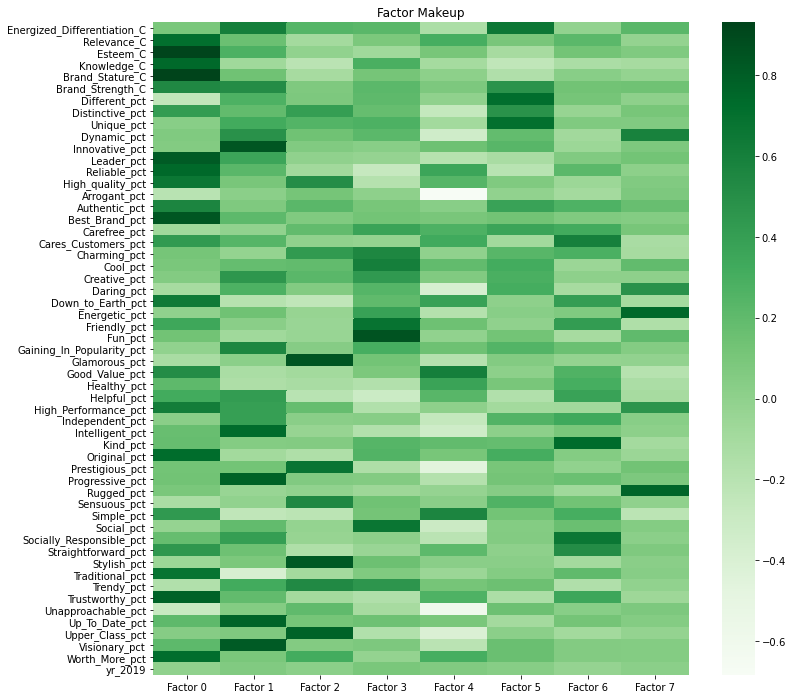

In [144]:
# Visualize
plt.figure(figsize=(12, 12))
sns.heatmap(loadings, cmap='Greens', fmt='g').set_title('Factor Makeup')
plt.show()

### Inspecting and Naming the Factors

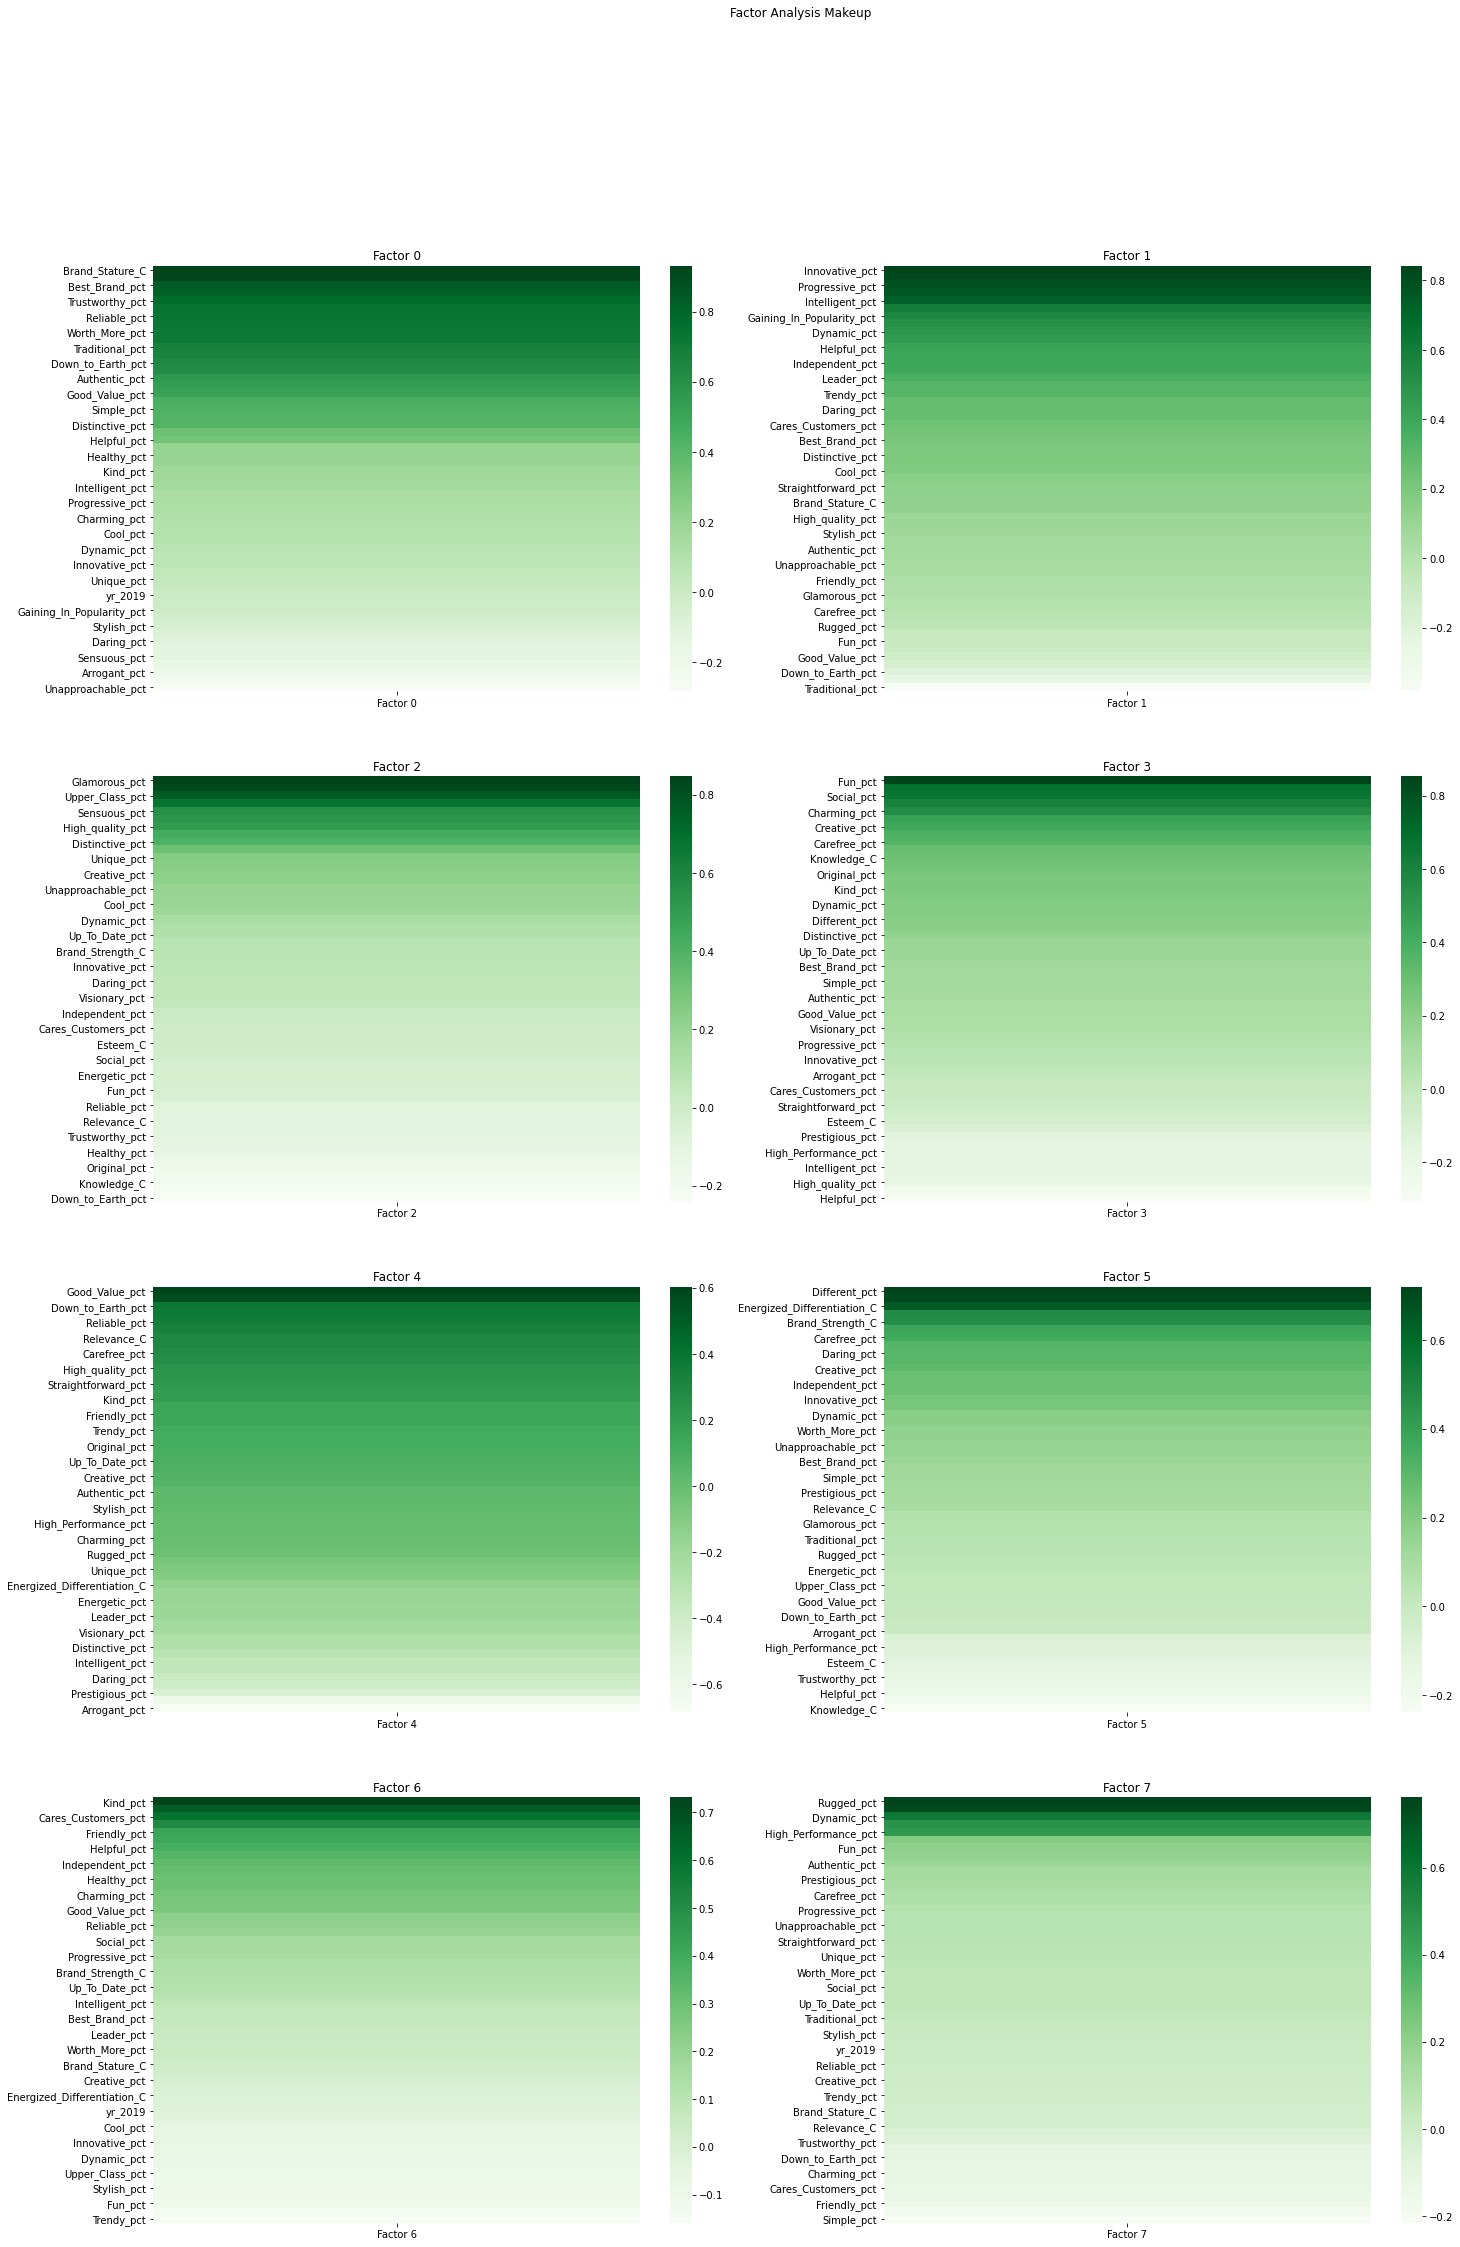

In [182]:
fig, axes = plt.subplots(4, 2, figsize=(24, 36))
fig.suptitle('Factor Analysis Makeup')

ax_ar = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
for i in range(8):
    sns.heatmap(loadings[['Factor {}'.format(i)]].sort_values(by='Factor {}'.format(i), ascending=False), cmap='Greens', fmt='g', ax=axes[ax_ar[i][0], ax_ar[i][1]]).set_title('Factor {}'.format(i))
    
plt.show()

This looks promising.   
I'll take a bit more time with the right names but at first glance these feel distinct and separate.   
Something like the below as a placeholder for now:   

- Factor 0: Reputation
- Factor 1: Cutting Edge
- Factor 2: Prestige
- Factor 3: Charisma
- Factor 4: Approachable
- Factor 5: Unique
- Factor 6: Thoughtful
- Factor 7: Advanced

## Next Steps

The Factor Analysis has been insightful and an appropriate trade-off in how to cluster the most influential factors. Will retain this 8 factor reduced dataset for the modeling phase.

I will reatin the PCA 7 reduced dataset for prediction purposes, in case there is a need for a separate prediction model.

I'm specifically interested to explore the effects of: High Correlation Filtering, Low Variance Filtering, and Random Forrests for Column Selection as outlined in this article:   
https://thenewstack.io/3-new-techniques-for-data-dimensionality-reduction-in-machine-learning/

### File Save Outs

In [66]:
# Assembling standard scaled dataset for save out
X_ = BAV_df.drop(['Recommend_to_a_friend_pct'], axis=1)
Xs_df = pd.DataFrame(data=scaler.transform(X_), columns=X_.columns)
Xs_df.index = y.index
BAV_scaled = pd.concat([y, Xs_df], axis=1)
BAV_scaled.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,yr_2019
Acura,9.632626,-0.002347,-0.787306,0.276346,0.782062,0.408922,-0.532561,-0.534627,0.374604,-0.505916,...,1.700738,-0.953525,0.524561,0.172321,0.111888,0.067217,1.632785,0.832706,0.012613,-0.977609
Alfa Romeo,5.360558,1.509067,-1.696354,-0.596668,-0.322769,-0.512688,-0.498050,0.686925,2.491879,1.336199,...,2.043090,-0.756703,0.596944,-1.014161,2.144682,-0.124812,4.041739,-0.315579,0.703253,-0.977609
Aston Martin,6.165359,1.560737,-1.847191,-0.615000,-0.120060,-0.449481,-0.606405,0.667869,2.747290,1.311986,...,1.906571,-1.281172,-0.023276,-1.002630,1.842162,-1.111623,5.075575,-0.077605,0.767481,-0.977609
Audi,8.403893,1.530181,-1.090829,0.273648,0.732929,0.381005,0.029230,0.035036,1.816371,0.858114,...,2.380227,-0.463282,0.821769,-0.531731,0.564688,0.037198,3.106204,0.340826,0.803661,-0.977609
Bentley,6.453038,1.672423,-1.776480,0.103549,0.272025,0.048799,-0.500444,0.725951,3.061281,2.035984,...,2.549381,0.205497,0.061694,-0.477410,2.657441,-0.639585,6.079881,-0.164264,1.481469,-0.977609


In [67]:
# Reminder of unscaled dataset
BAV_df.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,yr_2019
Acura,9.632626,0.588681,2.131318,0.536944,3.303892,1.774005,1.254666,8.081687,12.271390,8.301122,...,15.710160,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579,0
Alfa Romeo,5.360558,0.771191,1.648400,0.351125,2.040411,0.716439,1.271231,11.130420,17.817520,13.124450,...,17.267210,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341,0
Aston Martin,6.165359,0.777430,1.568270,0.347223,2.272228,0.788971,1.219220,11.082860,18.486561,13.061050,...,16.646311,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667,0
Audi,8.403893,0.773740,1.970076,0.536370,3.247704,1.741970,1.524328,9.503444,16.048050,11.872650,...,18.800541,8.386318,15.85582,12.400040,6.730000,10.951970,21.809719,11.357830,8.388798,0
Bentley,6.453038,0.790917,1.605834,0.500165,2.720615,1.360756,1.270082,11.227820,19.309050,14.956740,...,19.569870,11.032830,12.52582,12.685470,11.473560,9.141562,34.941780,9.720911,10.133530,0


In [191]:
# Assemble 8 Factor DataFrame
X_df = pd.DataFrame(data=fa.transform(X_), columns=factor_cols, index=X_.index)
BAV_factors_df = pd.concat([y, X_df], axis=1)
BAV_factors_df.head()

,Recommend_to_a_friend_pct,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
Acura,9.632626,35.636926,125.405846,-91.551305,-120.127291,-30.033217,688.867103,-177.457577,-34.348205
Alfa Romeo,5.360558,5751.602919,20290.301327,-15070.113086,-19460.707208,-4859.422463,112222.997514,-28664.191826,-5603.679246
Aston Martin,6.165359,3169.587763,11179.625580,-8301.871783,-10724.011267,-2678.437530,61835.819280,-15795.311232,-3087.544651
Audi,8.403893,-900.379732,-3177.982882,2363.364521,3047.646999,760.166649,-17579.460492,4488.664808,878.872646
Bentley,6.453038,-2104.047869,-7428.235122,5521.413412,7121.429233,1775.696858,-41077.105250,10490.493685,2051.306820


In [192]:
BAV_factors_df.shape

(6058, 9)

In [193]:
BAV_df.to_csv("../data/BAV_unscaled.csv")
BAV_scaled.to_csv("../data/BAV_scaled.csv")
BAV_pca7_df.to_csv("../data/BAV_pca7.csv")
BAV_factors_df.to_csv("../data/BAV_factors.csv")